In [1]:
import pandas as pd
import pmdarima as pm
import numpy as np
from datetime import datetime
from pmdarima import model_selection
from pmdarima import auto_arima
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Lee el archivo como un DataFrame
df  = pd.read_csv('data/sell-in.csv', delimiter='\t')
df_pid_validos  = pd.read_csv('data/productos_a_predecir.txt')

# Ajustar el ancho máximo de las columnas
pd.set_option('display.max_colwidth', None)

# Ajustar el ancho máximo de la visualización
pd.set_option('display.width', 1000)

# Muestra las primeras filas del DataFrame
print(df.head())
print(df_pid_validos.head())

   periodo  customer_id  product_id  plan_precios_cuidados  cust_request_qty  cust_request_tn       tn
0   201701        10234       20524                      0                 2          0.05300  0.05300
1   201701        10032       20524                      0                 1          0.13628  0.13628
2   201701        10217       20524                      0                 1          0.03028  0.03028
3   201701        10125       20524                      0                 1          0.02271  0.02271
4   201701        10012       20524                      0                11          1.54452  1.54452
   product_id
0       20001
1       20002
2       20003
3       20004
4       20005


In [3]:
product_ids_validos = df_pid_validos['product_id'].tolist()

In [4]:
df.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945818 entries, 0 to 2945817
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   periodo                int64  
 1   customer_id            int64  
 2   product_id             int64  
 3   plan_precios_cuidados  int64  
 4   cust_request_qty       int64  
 5   cust_request_tn        float64
 6   tn                     float64
dtypes: float64(2), int64(5)
memory usage: 157.3 MB


In [6]:
# Filtrar el DataFrame original para quedarse solo con los product_id válidos
data = df[df['product_id'].isin(product_ids_validos)]

In [7]:
data.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


In [8]:
# Suponiendo que tu DataFrame se llama df
#data.set_index('periodo', inplace=True)


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2293481 entries, 0 to 2945817
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   periodo                int64  
 1   customer_id            int64  
 2   product_id             int64  
 3   plan_precios_cuidados  int64  
 4   cust_request_qty       int64  
 5   cust_request_tn        float64
 6   tn                     float64
dtypes: float64(2), int64(5)
memory usage: 140.0 MB


In [10]:
# Función para realizar la predicción con auto_arima por product_id y customer_id
def predict_with_auto_arima(df):
    results = {}
    product_customer_ids = df[['product_id', 'customer_id']].drop_duplicates()

    for _, row in product_customer_ids.iterrows():
        product_id = row['product_id']
        customer_id = row['customer_id']
        
        print(f"Procesando product_id: {product_id}, customer_id: {customer_id}")
        
        product_customer_data = df[(df['product_id'] == product_id) & (df['customer_id'] == customer_id)]
        product_customer_data = product_customer_data.sort_values(by='periodo')
        
        # Asegurarse de que los datos están en el formato correcto
        y = product_customer_data['tn'].values
        
        # Manejar casos con datos insuficientes para la predicción
        if len(y) < 2:
            print(f"Datos insuficientes para el producto {product_id} y cliente {customer_id}, se omite la predicción.")
#            continue
        else:
            # Separar en entrenamiento y prueba (66/33)
            train_size = int(len(y) * 0.66)
            train, test = y[:train_size], y[train_size:]
            if len(train) < 2 or len(test) <= 1:
                print(f"Datos insuficientes para el producto {product_id} y cliente {customer_id} después de la división, se omite la predicción.")
#            continue
            else:
            # Ajustar el modelo en el conjunto de entrenamiento
            model = auto_arima(train, seasonal=False, error_action='ignore', suppress_warnings=True)
        
            # Predecir en el conjunto de prueba y calcular el error
            forecast = model.predict(n_periods=len(test))
            mse = mean_squared_error(test, forecast)
            print(f"MSE para product_id {product_id}, customer_id {customer_id}: {mse}")
        
            # Realizar la predicción para los próximos dos meses
            final_forecast = model.predict(n_periods=2)
            prediction_for_february = final_forecast[-1]
        
        if product_id not in results:
            results[product_id] = 0
        results[product_id] += prediction_for_february
        
        # Graficar las predicciones
        plt.figure(figsize=(10, 6))
        plt.plot(product_customer_data['periodo'].values, y, label='Datos reales')
        plt.plot(product_customer_data['periodo'].values[-len(test):], forecast, label='Predicción')
        plt.title(f'Product ID: {product_id}, Customer ID: {customer_id}')
        plt.xlabel('Periodo')
        plt.ylabel('tn')
        plt.legend()
        plt.show()
    
    return results

Procesando product_id: 20524, customer_id: 10234


C:\Users\hbasilio\AppData\Local\Temp\ipykernel_19048\1916487808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['periodo'] = pd.to_datetime(data['periodo'], format='%Y%m', errors='coerce')


MSE para product_id 20524, customer_id 10234: 0.002734639356000001


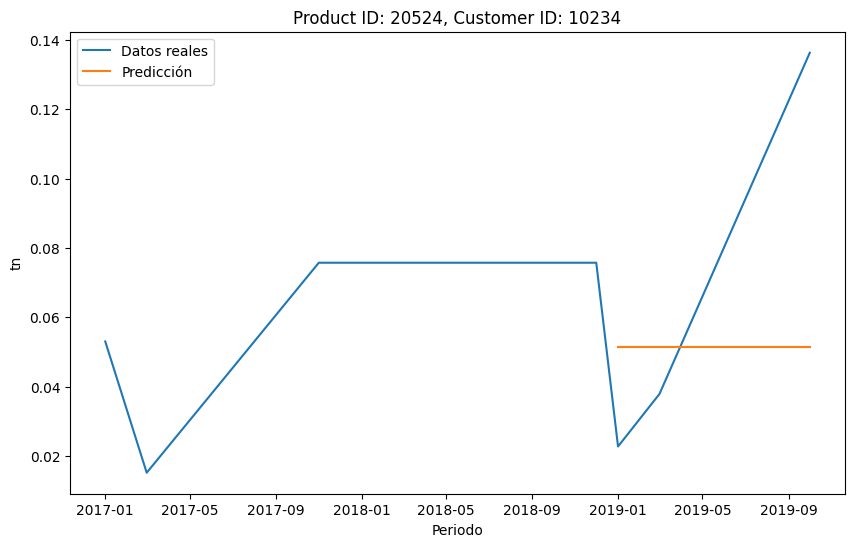

Procesando product_id: 20524, customer_id: 10032
MSE para product_id 20524, customer_id 10032: 0.00648625968743811


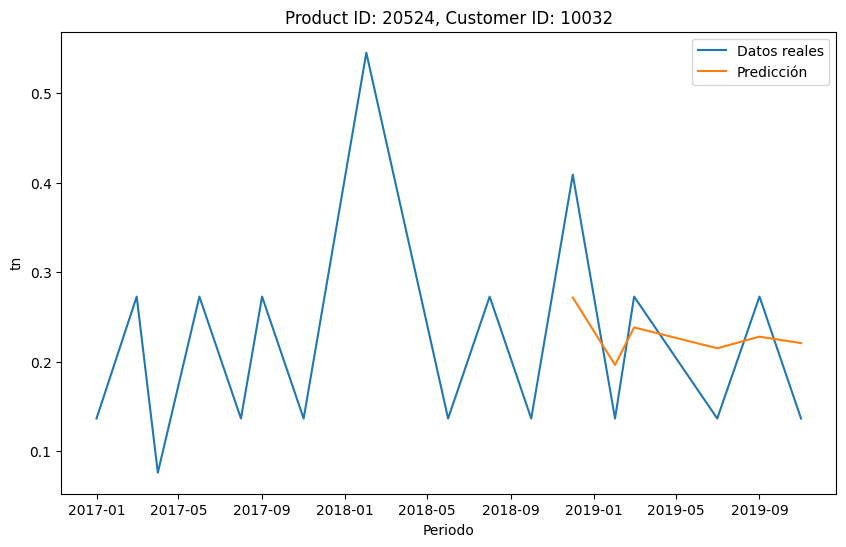

Procesando product_id: 20524, customer_id: 10217
MSE para product_id 20524, customer_id 10217: 0.0002150069444263215


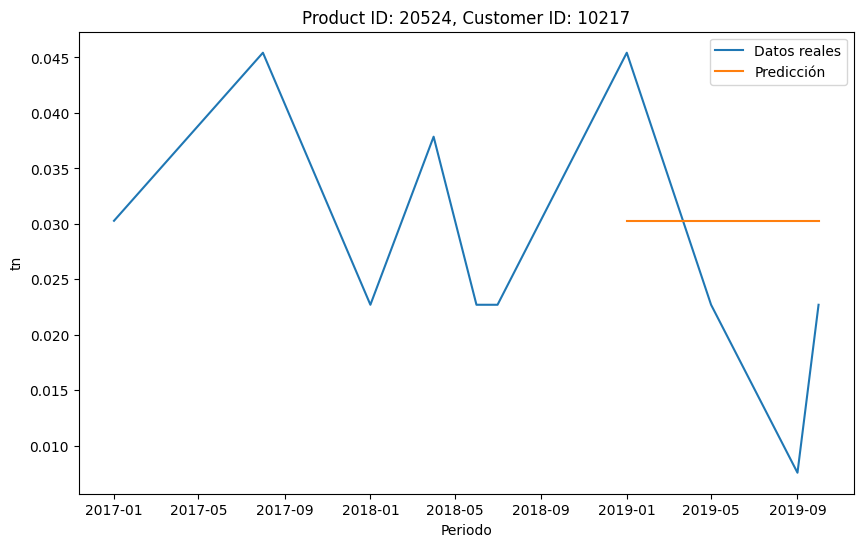

Procesando product_id: 20524, customer_id: 10125
MSE para product_id 20524, customer_id 10125: 1.4326224999566158e-05


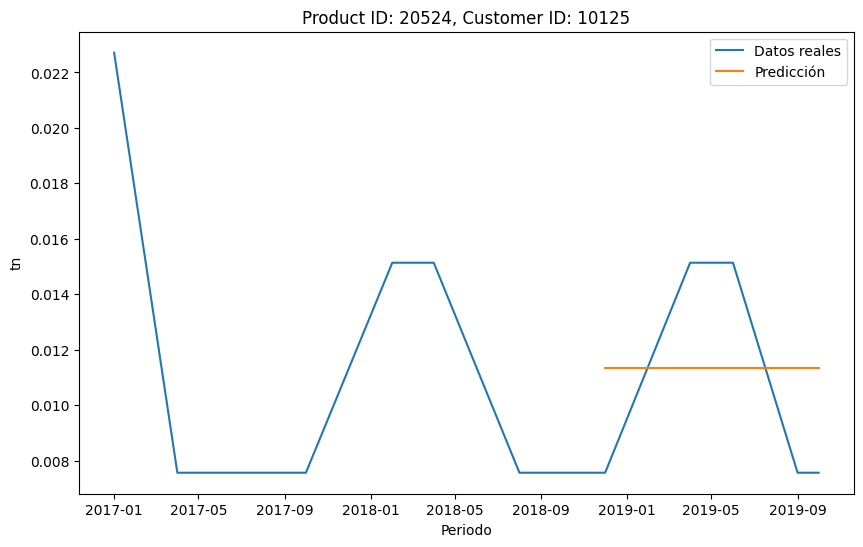

Procesando product_id: 20524, customer_id: 10012
MSE para product_id 20524, customer_id 10012: 0.3437611743618586


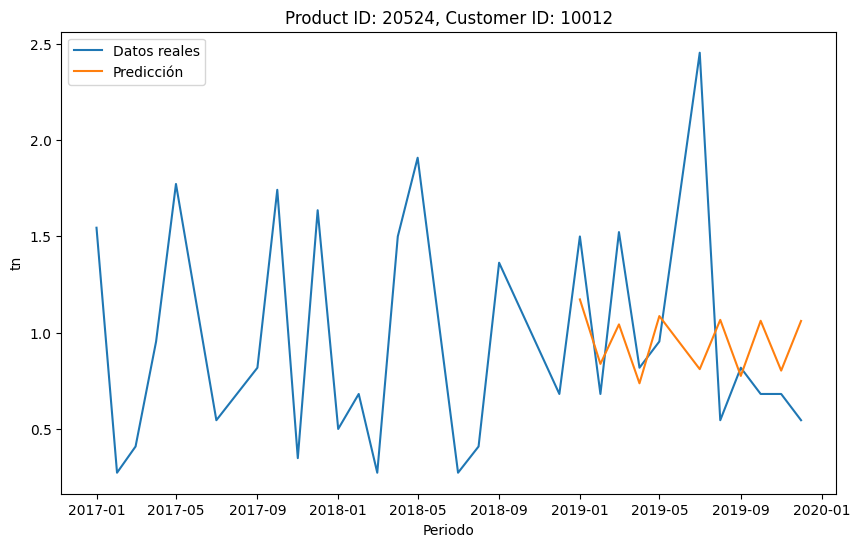

Procesando product_id: 20524, customer_id: 10080
MSE para product_id 20524, customer_id 10080: 3.310949777725366e-05


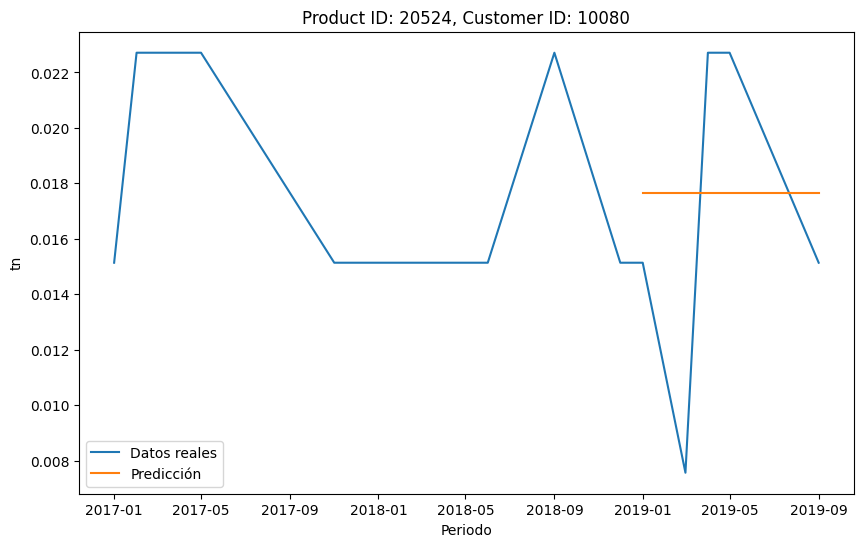

Procesando product_id: 20524, customer_id: 10015
MSE para product_id 20524, customer_id 10015: 0.0004422800429879742


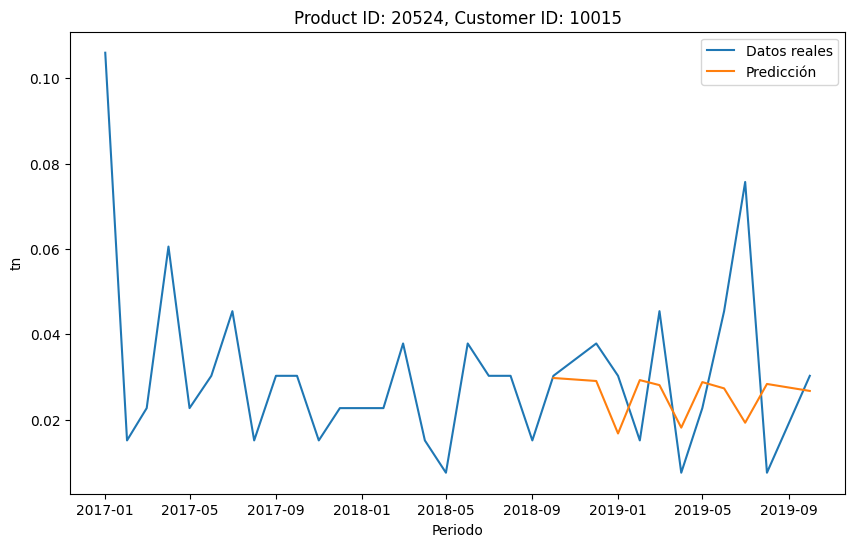

Procesando product_id: 20524, customer_id: 10062
MSE para product_id 20524, customer_id 10062: 0.007666505829222656


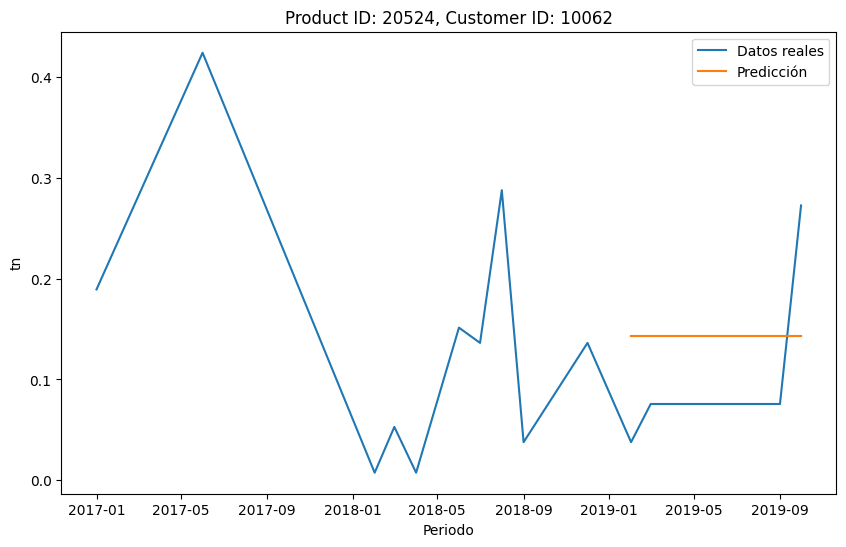

Procesando product_id: 20524, customer_id: 10159
MSE para product_id 20524, customer_id 10159: 0.00024096624056042332


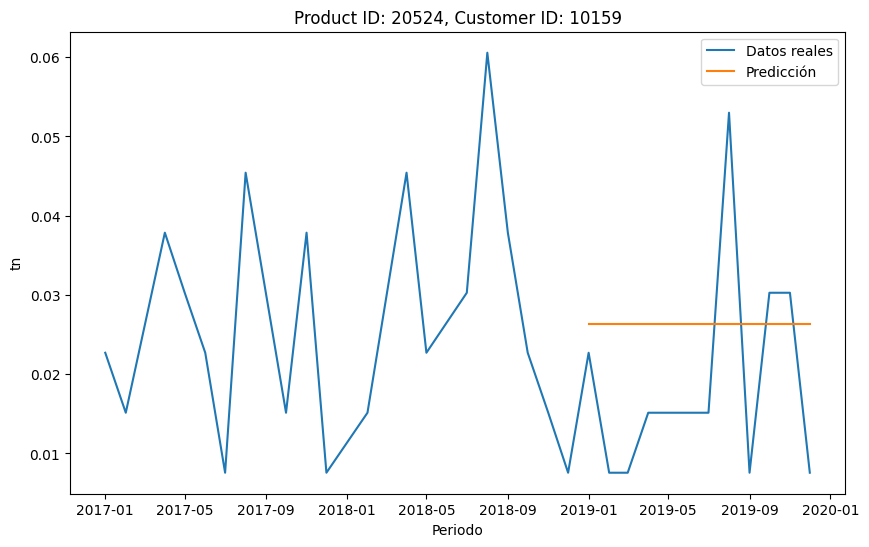

Procesando product_id: 20524, customer_id: 10183
MSE para product_id 20524, customer_id 10183: 3.34473497949403e-05


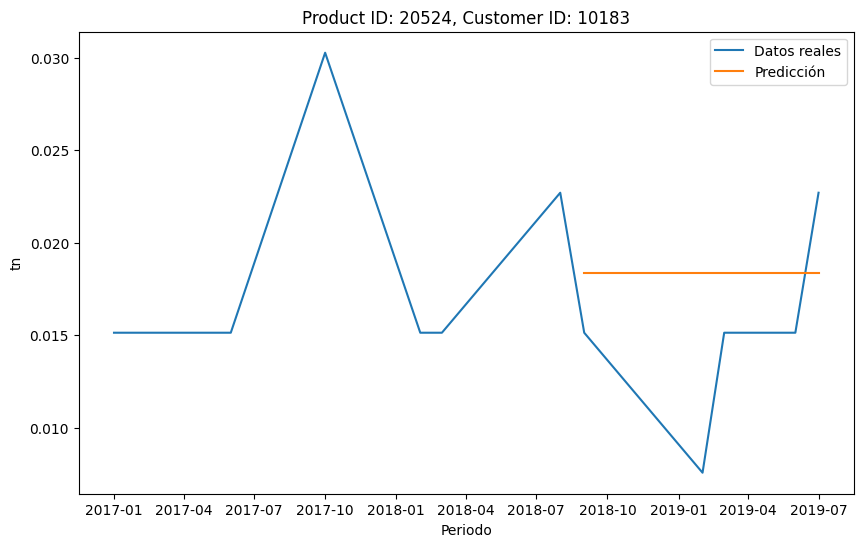

Procesando product_id: 20524, customer_id: 10394
Datos insuficientes para el producto 20524 y cliente 10394 después de la división, se omite la predicción.


ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

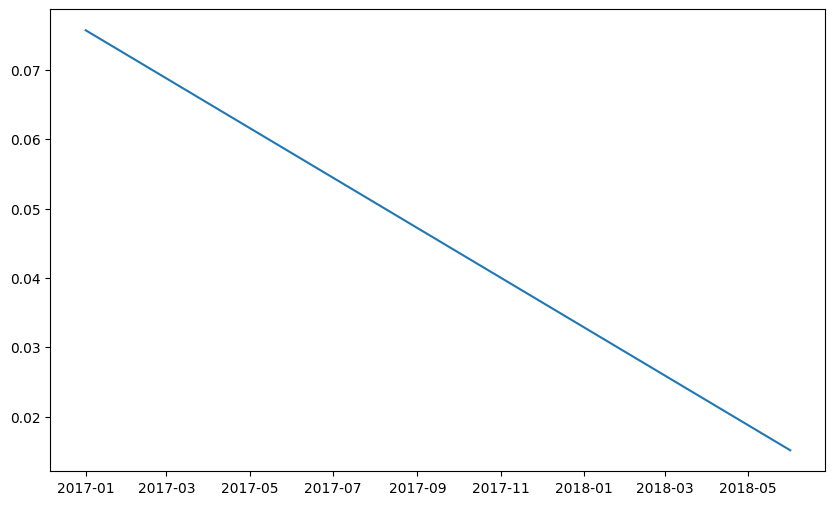

In [11]:
# Convertir la columna 'periodo' a datetime
data['periodo'] = pd.to_datetime(data['periodo'], format='%Y%m', errors='coerce')

# Realizar las predicciones
predictions = predict_with_auto_arima(data)

# Crear un DataFrame con los resultados y ordenar por 'product_id'
output_df = pd.DataFrame(list(predictions.items()), columns=['product_id', 'tn'])
output_df = output_df.sort_values(by='product_id')

# Guardar los resultados en un archivo CSV
output_df.to_csv('salida_autoarima_v6.0.csv', index=False)
print("Predicciones guardadas en salida_autoarima_v6.0.csv")